# Model Explanation Multiclass

## Dataset & Model Loading

In [4]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from treeinterpreter import treeinterpreter as ti
from IPython.display import display
from sklearn.base import BaseEstimator, TransformerMixin
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.text_preprocessing import preprocess_text, TextPreprocessor #Run Time Usage
from utils.bad_word_blurrer import blur_text



df_train = pd.read_csv("../dataset/training_set.csv")
df_train["text"] = df_train["text"].apply(preprocess_text)
df_voc = df_train[df_train["multiclass_label"] != "not_cyberbullying"].copy()
label2id = {label: idx for idx, label in enumerate(sorted(df_voc["multiclass_label"].unique()))}

df_filtered = pd.read_csv("../dataset/true_positive.csv")
df_filtered["text"] = df_filtered["text"].apply(preprocess_text)
df_filtered["label_id"] = df_filtered["multiclass_label"].map(label2id)

X_text = df_filtered["text"]
y_multiclass = df_filtered["label_id"]

pipeline_multiclass = joblib.load("../model/multiclass/RandomForest_TF-IDF_multiclass.pkl")
pipeline_binary = joblib.load("../model/binary/LogisticRegression_BoW.pkl")
rf_model = pipeline_multiclass.named_steps["model"]       
lr_binary = pipeline_binary.named_steps["model"]          

tfidf_vectorizer = pipeline_multiclass.named_steps["vectorizer"]
BoW_vectorizer_binary = pipeline_binary.named_steps["vectorizer"]

print("Multiclass pipeline steps:")
print(pipeline_multiclass.steps)
print("\nBinary pipeline steps:")
print(pipeline_binary.steps)

print("\nExtracted model types:")
print("Multiclass model:", type(rf_model))
print("Binary model:   ", type(lr_binary))

print("\nMulticlass vocab size:", len(tfidf_vectorizer.get_feature_names_out()))
print("Binary vocab size:   ", len(BoW_vectorizer_binary.get_feature_names_out()))



Multiclass pipeline steps:
[('preprocessing', TextPreprocessor()), ('vectorizer', TfidfVectorizer(max_features=350)), ('model', RandomForestClassifier(n_estimators=500, random_state=42))]

Binary pipeline steps:
[('preprocessing', TextPreprocessor()), ('vectorizer', CountVectorizer(max_features=350)), ('smote', SMOTE(random_state=42)), ('model', LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000))]

Extracted model types:
Multiclass model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Binary model:    <class 'sklearn.linear_model._logistic.LogisticRegression'>

Multiclass vocab size: 350
Binary vocab size:    350


## Local Multiclass Model Explanation

In [5]:
pd.set_option("display.max_rows", 400)
pd.set_option("display.max_columns", 0)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.expand_frame_repr", False)

df_correct_examples = pd.read_csv("../dataset/selected_explanable_example.csv")

X_example_tfidf = tfidf_vectorizer.transform(df_correct_examples["text"]).toarray().astype("float32")
feature_names = tfidf_vectorizer.get_feature_names_out() 

for i in range(len(df_correct_examples)-1):
    label_id = df_correct_examples.loc[i, "label_id"]
    label_name = df_correct_examples.loc[i, "label_name"]
    text = df_correct_examples.loc[i, "text"]
    
    x = X_example_tfidf[i].reshape(1, -1)

    prediction, bias, contributions = ti.predict(rf_model, x)
    predicted_label_id = np.argmax(prediction)

    data = []
    for j in range(len(feature_names)):
        data.append({
            "feature": blur_text(feature_names[j]),
            "contribution": contributions[0][j][predicted_label_id], 
            "tfidf_value": x[0][j]
        })

    df_interp = pd.DataFrame(data)
    df_interp_sorted = df_interp.reindex(df_interp.contribution.abs().sort_values(ascending=False).index)

    print(f"\n=== TreeInterpreter Explanation ===")
    print(f"True class: {label_id} ({label_name})")
    print(f"Predicted class: {predicted_label_id}")
    print(f"Text preview: {text[:150]}...\n")
    print(f"Bias (expected value): {bias[0][predicted_label_id]:.4f}")
    print(f"Prediction (probabilities): {prediction[0]}")
    
    display(df_interp_sorted.head(25))
    print("=" * 100)



=== TreeInterpreter Explanation ===
True class: 0 (age)
Predicted class: 0
Text preview: realli hope bulli gay school...

Bias (expected value): 0.2010
Prediction (probabilities): [0.952 0.004 0.016 0.024 0.004]


,feature,contribution,tfidf_value
256,school,0.470376,0.305985
36,bulli,0.290215,0.291867
99,g*y,-0.051987,0.383929
124,high,-0.044706,0.000000
101,girl,-0.033027,0.000000
242,r**e,0.031070,0.000000
149,joke,0.028900,0.000000
129,hope,-0.012733,0.636926
205,n****r,0.007695,0.000000
194,muslim,0.006510,0.000000



=== TreeInterpreter Explanation ===
True class: 1 (ethnicity)
Predicted class: 1
Text preview: dumb nigger fuck...

Bias (expected value): 0.2003
Prediction (probabilities): [0. 1. 0. 0. 0.]


,feature,contribution,tfidf_value
205,n****r,0.308467,0.588248
69,dumb,0.284540,0.596447
95,f**k,0.161107,0.546091
36,bulli,0.014078,0.000000
256,school,0.012797,0.000000
20,a*s,-0.011947,0.000000
33,black,-0.007491,0.000000
194,muslim,0.006266,0.000000
242,r**e,0.005476,0.000000
99,g*y,0.005120,0.000000



=== TreeInterpreter Explanation ===
True class: 2 (gender)
Predicted class: 2
Text preview: rt im sexist hate woman sport comment...

Bias (expected value): 0.2008
Prediction (probabilities): [0.    0.002 0.988 0.002 0.008]


,feature,contribution,tfidf_value
262,sexist,0.444893,0.434186
251,rt,0.125590,0.324170
137,im,0.069607,0.316331
334,woman,0.064076,0.405737
242,r**e,-0.029439,0.000000
44,christian,0.027505,0.000000
99,g*y,-0.027086,0.000000
149,joke,-0.026634,0.000000
36,bulli,0.019817,0.000000
256,school,0.017614,0.000000



=== TreeInterpreter Explanation ===
True class: 3 (other_cyberbullying)
Predicted class: 3
Text preview: plz follow us back help maja hard time life like bulli cut read stori bio...

Bias (expected value): 0.1967
Prediction (probabilities): [0.138 0.008 0.006 0.834 0.014]


,feature,contribution,tfidf_value
256,school,0.218975,0.000000
36,bulli,-0.081986,0.157540
164,like,-0.056147,0.190678
124,high,0.040932,0.000000
101,girl,0.035312,0.000000
282,stori,0.022400,0.371788
194,muslim,0.021394,0.000000
116,hard,0.021009,0.360546
121,help,0.019937,0.336527
301,time,0.019603,0.267740



=== TreeInterpreter Explanation ===
True class: 4 (religion)
Predicted class: 4
Text preview: visit muslim countri see woke right your behead like british girl idiot thought vacat morocco good idea dont blond err mean stupid...

Bias (expected value): 0.2012
Prediction (probabilities): [0.016 0.006 0.01  0.006 0.962]


,feature,contribution,tfidf_value
194,muslim,0.340259,0.203174
134,idiot,0.255842,0.212861
250,right,0.057765,0.244585
54,countri,0.048938,0.305709
101,girl,-0.032492,0.190535
36,bulli,0.023709,0.000000
256,school,0.018333,0.000000
44,christian,-0.017433,0.000000
142,islam,-0.011007,0.000000
95,f**k,0.009378,0.000000


## Global Multiclass Model Explanation

/var/folders/k5/2x805v8s36zft24jm8_zy2980000gn/T/ipykernel_2222/3352415407.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top["feature"] = df_top["feature"].apply(blur_text)


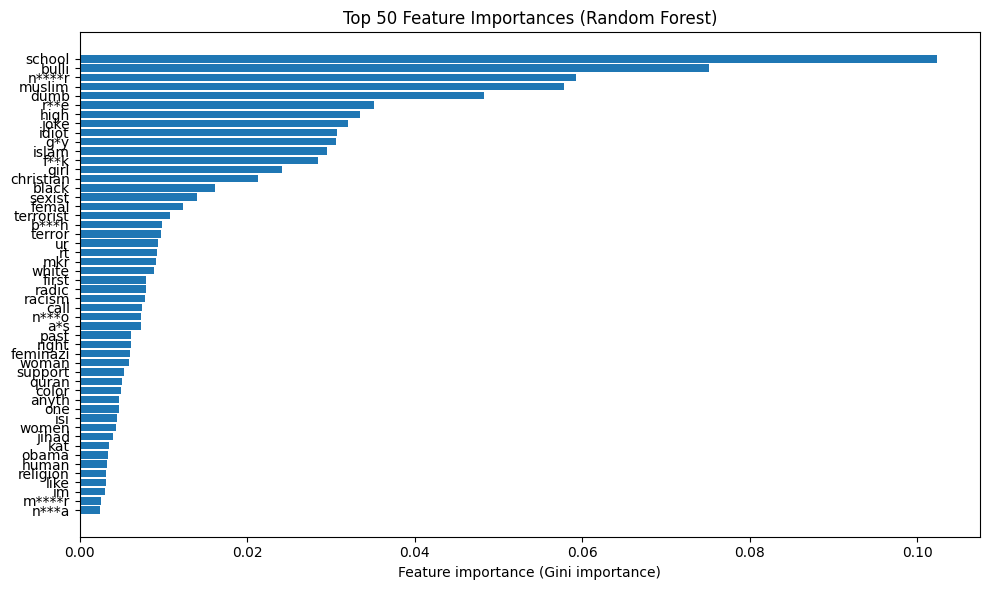

In [6]:
importances = rf_model.feature_importances_

feature_names = tfidf_vectorizer.get_feature_names_out()

df_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

top_k = 50
df_top = df_importances.head(top_k)

df_top["feature"] = df_top["feature"].apply(blur_text)

plt.figure(figsize=(10, 6))
plt.barh(df_top["feature"][::-1], df_top["importance"][::-1])
plt.xlabel("Feature importance (Gini importance)")
plt.title("Top 50 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


